The tile coordinates are (1560, 3288, 1560, 3288)


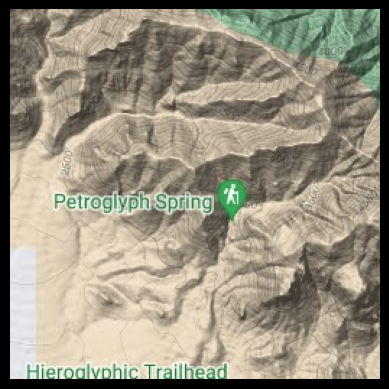

The map has successfully been created


In [45]:
#!/usr/bin/python
# GoogleMapDownloader.py
# Created by Hayden Eskriett [http://eskriett.com]
#
# A script which, when given a bounding box (west, east, south, north) and zoom level, downloads a
# high-resolution Google map

import urllib.request
from PIL import Image
import os
import math
import matplotlib.pyplot as plt
import datetime

class GoogleMapsLayers:
    ROADMAP = "v"
    TERRAIN = "p"
    ALTERED_ROADMAP = "r"
    SATELLITE = "s"
    TERRAIN_ONLY = "t"
    HYBRID = "y"

class GoogleMapDownloader:
    """
    A class which generates high-resolution Google Maps images given
    a bounding box (west, east, south, north) and zoom level.
    """

    def __init__(self, west, east, south, north, zoom=12, layer=GoogleMapsLayers.ROADMAP):
        """
        GoogleMapDownloader Constructor
        Args:
            west:The longitude of the west boundary
            east:The longitude of the east boundary
            south:The latitude of the south boundary
            north:The latitude of the north boundary
            zoom:The zoom level of the location required, ranges from 0 - 23 (defaults to 12)
            layer:The type of map layer (defaults to ROADMAP)
        """
        self._west = west
        self._east = east
        self._south = south
        self._north = north
        self._zoom = zoom
        self._layer = layer

    def getXY(self):
        """
        Generates top-left and bottom-right X, Y tile coordinates based on the bounding box and zoom level.
        Returns:    top_left_x, top_left_y, bottom_right_x, bottom_right_y
        """
        tile_size = 256

        # Use a left shift to get the power of 2
        num_tiles = 1 << self._zoom

        # Find the top-left coordinates
        top_left_x = (tile_size / 2 + self._west * tile_size / 360.0) * num_tiles // tile_size
        sin_top_left_y = math.sin(self._north * (math.pi / 180.0))
        top_left_y = ((tile_size / 2) + 0.5 * math.log((1 + sin_top_left_y) / (1 - sin_top_left_y)) * -(
            tile_size / (2 * math.pi))) * num_tiles // tile_size

        # Find the bottom-right coordinates
        bottom_right_x = (tile_size / 2 + self._east * tile_size / 360.0) * num_tiles // tile_size
        sin_bottom_right_y = math.sin(self._south * (math.pi / 180.0))
        bottom_right_y = ((tile_size / 2) + 0.5 * math.log((1 + sin_bottom_right_y) / (1 - sin_bottom_right_y)) * -(
            tile_size / (2 * math.pi))) * num_tiles // tile_size

        return int(top_left_x), int(top_left_y), int(bottom_right_x), int(bottom_right_y)

    def generateImage(self, **kwargs):
        """
        Generates an image by stitching a number of Google Map tiles together.

        Args:
            start_x:The top-left x-tile coordinate
            start_y:The top-left y-tile coordinate
            tile_width:The number of tiles wide the image should be - defaults to 5
            tile_height:The number of tiles high the image should be - defaults to 5
        Returns:
            A high-resolution Google Map image.
        """

        start_x = kwargs.get('start_x', None)
        start_y = kwargs.get('start_y', None)
        tile_width = kwargs.get('tile_width', 1) # zoom * times:
        tile_height = kwargs.get('tile_height', 1)

        # Check that we have x and y tile coordinates
        if start_x is None or start_y is None:
            start_x, start_y, _, _ = self.getXY()

        # Determine the size of the image
        width, height = 256 * tile_width, 256 * tile_height

        # Create a new image of the size required
        map_img = Image.new('RGB', (width, height))

        for x in range(0, tile_width):
            for y in range(0, tile_height):
                url = f'https://mt0.google.com/vt?lyrs={self._layer}&x=' + str(start_x + x) + '&y=' + str(start_y + y) + '&z=' + str(
                    self._zoom)

                current_tile = str(x) + '-' + str(y)
                urllib.request.urlretrieve(url, current_tile)

                im = Image.open(current_tile)
                map_img.paste(im, (x * 256, y * 256))

                os.remove(current_tile)

        return map_img

def main():
    # Specify the bounding box coordinates
    # west, east, south, north = -111.94032, -111.93792, 33.42275, 33.42407
    west, east, south, north = -111.44188, -111.43596, 33.42211, 33.42484

    # Create a new instance of GoogleMap Downloader
    gmd = GoogleMapDownloader(west, east, south, north, 13, GoogleMapsLayers.TERRAIN)

    print("The tile coordinates are {}".format(gmd.getXY()))

    try:
        
        # Get the high-resolution image
        img = gmd.generateImage()
        # Display the image using matplotlib
        plt.imshow(img)
        plt.axis('off')  # Hide axis labels
        plt.show()
    except IOError:
        print("Could not generate the image - try adjusting the zoom level and checking your coordinates")
    else:
        # Save the image to disk
        info = "w-"+str(west)+"e-"+str(east)+"s-"+str(south)+"n-"+str(north)
        mark = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        img.save("./Data/download/"+info+"-"+mark+".png")
        print("The map has successfully been created")

if __name__ == '__main__':
    main()
